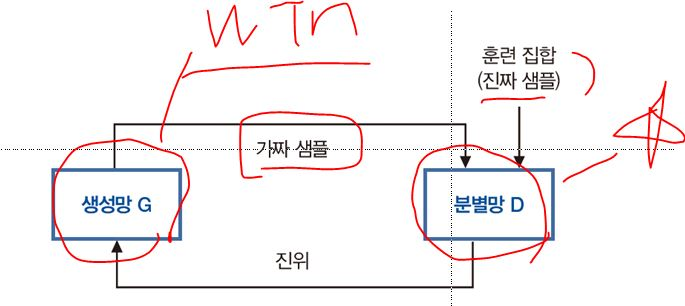

In [3]:
from IPython import display
display.Image('/content/038.JPG', width = 500, height = 500)

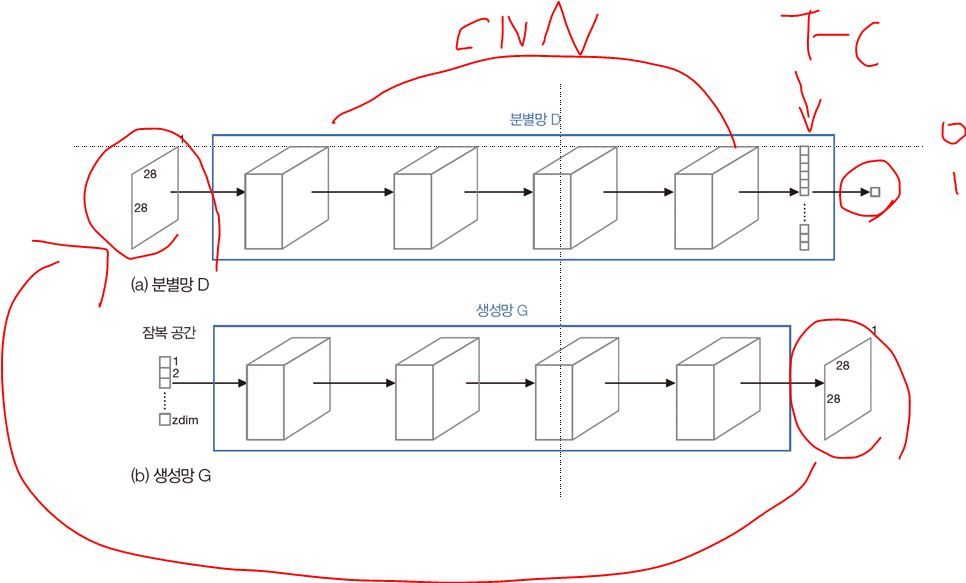

In [5]:
# 구조
display.Image('/content/039.JPG', width = 500, height = 500)

In [ ]:
# MNIST를 가지고 GAN을 구현하는 프로그램

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

In [7]:
# mnist 데이터를 load
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [8]:
x_train = x_train.astype(np.float32)/255.0*2.0 - 1.0 # -1 ~ 1 까지의 구간
x_test = x_test.astype(np.float32)/255.0*2.0 - 1.0
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [9]:
batch_size = 64
epoch = 5000
dropout_rate = 0.4
batch_norm = 0.9
zdim = 100

In [10]:
# # 분별망 D 설계
discriminator_input=Input(shape=(28, 28, 1))
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

In [11]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0     

In [12]:
# 생성망 G 설계
generator_input = Input(shape=(zdim,))
x = Dense(3136)(generator_input)
x = BatchNormalization(momentum=batch_norm)(x)
x = Activation('relu')(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128,(5,5),padding='same')(x)
x = BatchNormalization(momentum=batch_norm)(x)
x = Activation('relu')(x)
x=UpSampling2D()(x)
x = Conv2D(64,(5,5),padding='same')(x)
x = BatchNormalization(momentum=batch_norm)(x)
x = Activation('relu')(x)
x = Conv2D(64,(5,5),padding='same')(x)
x = BatchNormalization(momentum=batch_norm)(x)
x = Activation('relu')(x)
x = Conv2D(1,(5,5),activation = 'tanh', padding='same')(x)
generator_output = x
generator = Model(generator_input,generator_output)

In [13]:
generator.summary(())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                         

In [14]:
discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
# 생성망의 학습 설정
discriminator.trainable=False
gan_input = Input(shape=(zdim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# 분별망 학습
def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_size)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_size,1)))

    p=np.random.normal(0,1,(batch_size,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_size,1)))

In [23]:
# 분별망 학습 함수
def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_size)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_size,1)))

    p=np.random.normal(0,1,(batch_size,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_size,1)))

In [24]:
#생성망 학습 함수
def train_generator():
    p=np.random.normal(0,1,(batch_size,zdim))
    gan.train_on_batch(p,np.ones((batch_size,1)))

In [ ]:
for i in range(epoch+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

2/2 [==============================] - 0s 149ms/step


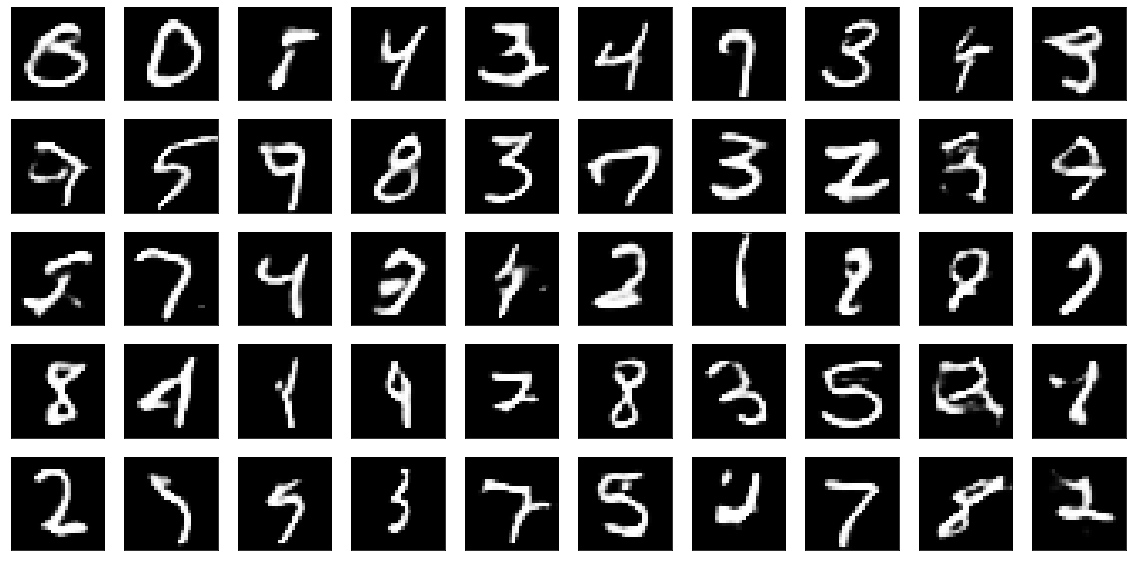

In [27]:
# 학습을 마친 후 50개의 샘플을 생성하여 출력

imgs = generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);